In [1]:
import os
import pandas as pd

import sys
from datetime import datetime
sys.path.append('../../Scripts')

표준테이블 목록
|순번|테이블명|설명|획득방법|
|:-:|:-:|:-:|:-:|
|1|교차로번호      |각 교차로의 이름, 위치|DB|
|2|방위각정보      |각 교차로의 (현시, 링)별 진입·진출 방위각|DB|
|3|이동류번호      |각 교차로의 (현시, 링)별 이동류번호|DB|
|4|신호계획        |각 교차로의 신호계획|DB|
|5|신호이력        |각 교차로의 (현시, 링)별 현시시간|DB|
|6|교차로-노드 매칭 |교차로번호와 노드ID를 매칭정보 및 parent/child 여부|수작업|
|7|유턴교차로정보   |각 유턴교차로별 부모교차로, 방향, 유턴옵션|수작업|
|8|연동교차로정보   |각 연동교차로별 부모교차로, (현시, 링)별 진입진출ID|수작업|
|9|NEMA 정보       |NEMA에서 정의한 이동류번호에 대한 진입·진출 방향|수작업|
|10|<미정>         |(현시, 링)별로 이동류번호가 두 개 이상 부여된 경우에 대비한 테이블|수작업|

스크립트 목록
|스크립트명|`preprocess_daily.py`|`generate_signal.py`|
|:-:|:-:|:-:|
|실행주기|매일|매5분|
|목적|신호생성에 사용되는 중간산출물 생성|실시간 신호파일 생성|
|산출물목록|`match.csv`<br>`match6.csv`<br>`matching.csv`<br>`node2num_cycles.json`|`sn_[timestamp].add.xml`|

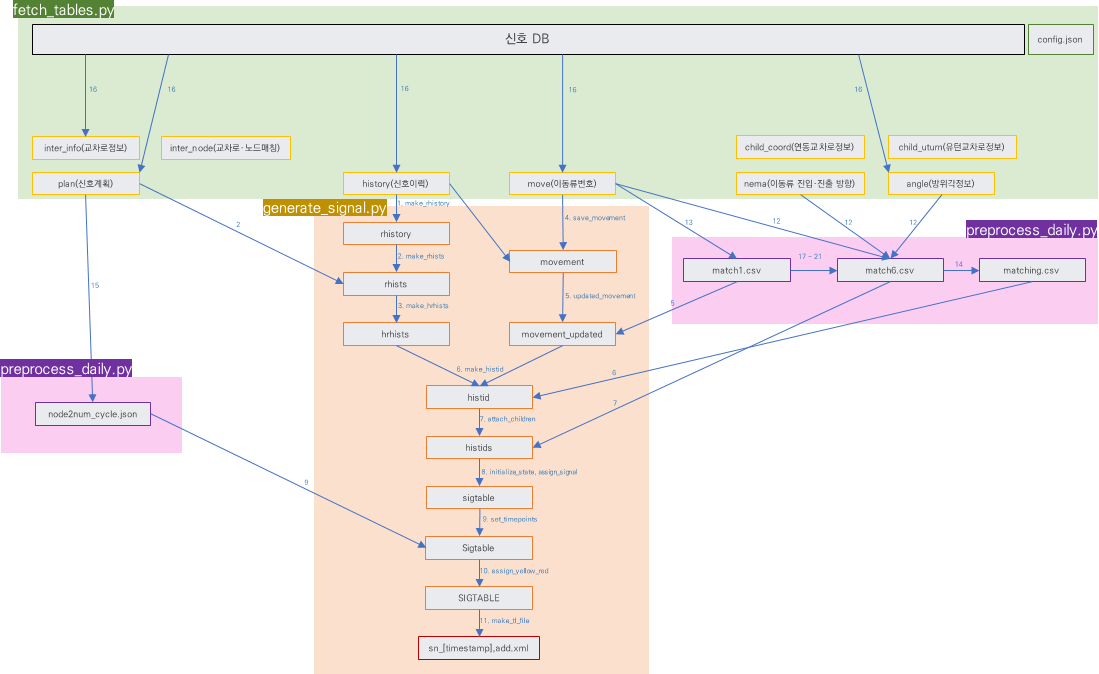

## `preprocess_daily.py`

In [2]:
# 매일 실행하는 스크립트
from preprocess_daily import DailyPreprocessor
dp = DailyPreprocessor()

# 1. 데이터 불러오기
dp.load_data()
# 2. 중간산출물 만들기
dp.get_intermediates()
# 3. 이슈사항 저장
dp.write_issues()

1. 데이터를 로드합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
1-3. 네트워크의 모든 clean state requirement들을 체크했습니다.
1-4. 테이블들의 무결성 검사를 완료했습니다.
2. 중간산출물을 생성합니다.


이동류정보 불러오는 중: 100%|██████████| 17280/17280 [00:14<00:00, 1213.47it/s]


2-1. 매칭 테이블들을 생성했습니다.
2-2. 비보호우회전(g)을 배정했습니다.
2-3. 직진 및 좌회전(G)을 배정했습니다.
2-2. node2num_cycles.json를 저장했습니다.
3. 이슈사항을 저장합니다.


In [3]:
# 2-1-1 match1 : 각 교차로마다 (A현시번호, B현시번호)를 (A이동류번호, B이동류번호)로 대응시키는 테이블입니다.
# 이러한 대응은 유일하지 않을 수 있지만(시차제), 임의의 대응 하나만 만들어놓아도 전체 프로세스에는 문제 없습니다.
dp.match1[:15]
# 이때, [표준테이블 3 : 이동류정보]를 사용합니다.
# [이동류정보] 테이블은 매 1초마다 바뀌는 테이블로서, 스크립트는 5초마다 한번씩 이 테이블을 불러옵니다.
# path_move = os.path.join(dp.path_tables, 'move')
# move = pd.read_csv(os.path.join(path_move, os.listdir(path_move)[400]), index_col=0)
# move

inter_no  phas_A  phas_B  move_A  move_B
0        175       1       1       8       4
1        175       2       2       7       3
2        175       3       3       6       1
3        175       3       4       6       2
4        175       4       4       5       2
5        176       1       1       8       4
6        176       2       2       8       3
7        176       3       3       5      18
8        177       1       1       8       4
9        177       2       2       7       3
10       177       3       3      17      18
11       177       4       4       5       1
12       178       1       1       8       4
13       178       2       2       7       3
14       178       3       3       5       2

In [4]:
# 2-1-2 match2 : match1을 계층화합니다. (세로로 길게 늘립니다.)
dp.match2[:15]

inter_no  phase_no ring_type  move_no
0       175         1         A        8
0       175         1         B        4
1       175         2         A        7
1       175         2         B        3
2       175         3         A        6
2       175         3         B        1
4       175         4         A        5
3       175         4         B        2
5       176         1         A        8
5       176         1         B        4
6       176         2         A        8
6       176         2         B        3
7       176         3         A        5
7       176         3         B       18
8       177         1         A        8

In [5]:
# 2-1-3 match3 : 각 행에 진입방향, 진출방향을 부여합니다.
dp.match3[:15]
# 이때 [표준테이블 9 : NEMA 정보]를 사용합니다.
# [NEMA 정보] 테이블은 한 번 만들어두고 계속 사용하는 테이블입니다.
# dp.nema

inter_no  phase_no ring_type  move_no inc_dir out_dir
0        175         1         A        8       남       북
1        175         1         B        4       북       남
2        175         2         A        7       북       동
3        175         2         B        3       남       서
4        175         3         A        6       동       서
5        175         3         B        1       동       남
6        175         4         A        5       서       북
7        175         4         B        2       서       동
8        176         1         A        8       남       북
9        176         1         B        4       북       남
10       176         2         A        8       남       북
11       176         2         B        3       남       서
12       176         3         A        5       서       북
13       176         3         B       18     NaN     NaN
14       177         1         A        8       남       북

In [7]:
# 2-1-4 match4 : 각 행에 진입각도, 진출각도를 부여합니다.
dp.match4[:15]
# 이때 [표준테이블 2 : 방위각정보]를 사용합니다.
# [방위각정보] 테이블은 하루에 한 번씩 업데이트되는 테이블입니다.
# dp.angle

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle
0        175         1         A        8       남       북       179       004
1        175         1         B        4       북       남       003       176
2        175         2         A        7       북       동       001       095
3        175         2         B        3       남       서       179       270
4        175         3         A        6       동       서       090       270
5        175         3         B        1       동       남       090       180
6        175         4         A        5       서       북       268       000
7        175         4         B        2       서       동       270       090
8        176         1         A        8       남       북       180       000
9        176         1         B        4       북       남       359       180
10       176         2         A        8       남       북       180       000
11       176         2         B        3       남       서       180       270
12       176         3         A        5       서       북       270       356
13       176         3         B       18     NaN     NaN       NaN       NaN
14       177         1         A        8       남       북       180       000

In [8]:
# 2-1-5 match5 : 각 행에 진입엣지id, 진출엣지id를 부여합니다.
# 이때 네트워크 파일을 사용하며, shape와 코사인유사도(내적)을 사용하는 과정이 있습니다.
dp.match5[:20]

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0        175         1         A        8       남       북       179       004   
1        175         1         B        4       북       남       003       176   
2        175         2         A        7       북       동       001       095   
3        175         2         B        3       남       서       179       270   
4        175         3         A        6       동       서       090       270   
5        175         3         B        1       동       남       090       180   
6        175         4         A        5       서       북       268       000   
7        175         4         B        2       서       동       270       090   
8        176         1         A        8       남       북       180       000   
9        176         1         B        4       북       남       359       180   
10       176         2         A        8       남       북       180       000   
11       176         2         B        3       남       서       180       270   
12       176         3         A        5       서       북       270       356   
13       176         3         B       18     NaN     NaN       NaN       NaN   
14       177         1         A        8       남       북       180       000   
15       177         1         B        4       북       남       001       176   
16       177         2         A        7       북       동       000       090   
17       177         2         B        3       남       서       179       270   
18       177         3         A       17     NaN     NaN       NaN       NaN   
19       177         3         B       18     NaN     NaN       NaN       NaN   

           inc_edge          out_edge node_id  
0     -571542797_02      571500487_01      i0  
1     -571500487_01      571542797_02      i0  
2     -571500487_01      571545870_01      i0  
3     -571542797_02      571510153_01      i0  
4      571545870_02      571510153_01      i0  
5      571545870_02      571542797_02      i0  
6      571510153_02      571500487_01      i0  
7      571510153_02      571545870_01      i0  
8     -571542810_01  -571542797_02.99      i1  
9   571542797_02.99      571542810_01      i1  
10    -571542810_01  -571542797_02.99      i1  
11    -571542810_01      571543469_01      i1  
12     571543469_02  -571542797_02.99      i1  
13              NaN               NaN      i1  
14    -571542809_01      571542811_01      i2  
15     571542811_02      571542809_01      i2  
16     571542811_02      571542107_01      i2  
17    -571542809_01      571542809_01      i2  
18              NaN               NaN      i2  
19              NaN               NaN      i2

In [9]:
# 2-1-6 match6 : 부교차로(유턴교차로와 연동교차로)에도 진입엣지id, 진출엣지id를 부여합니다.
# 부교차로의 다른 컬럼들 (inter_no ~ out_angle)은 주교차로의 값을 그대로 따릅니다.
# 부교차로의 진입엣지id, 진출엣지id는 별도로 부여되지 않으면 NaN이 됩니다.
# 마지막으로 노드id(네트워크에서의 junction id)도 부여됩니다.
dp.match6[:60]

# 이때 [표준테이블 6 : 교차로-노드 매칭]과 [표준테이블 7 : 유턴교차로정보], [표준테이블 8 : 연동교차로정보]가 사용됩니다.
# dp.inter_node
# dp.uturn
# dp.load_tables()
# dp.coord

inter_no node_id  phase_no ring_type  move_no                 state
0        175      i0         1         A        8     grrrgrrrgGGGGrgrr
1        175      i0         1         B        4     gGGrgrrrgrrrrrgrr
2        175      i0         2         A        7     grrGgrrrgrrrrrgrr
3        175      i0         2         B        3     grrrgrrrgrrrrGgrr
4        175      i0         3         A        6     grrrgGGrgrrrrrgrr
5        175      i0         3         B        1     grrrgrrGgrrrrrgrr
6        175      i0         4         A        5     grrrgrrrgrrrrrgrG
7        175      i0         4         B        2     grrrgrrrgrrrrrgGr
8        175     u00         1         A        8             ggggrgggg
9        175     u00         1         B        4             ggggrgggg
10       175     u00         2         A        7             ggggGgggg
11       175     u00         2         B        3             ggggrgggg
12       175     u00         3         A        6             ggggrgggg
13       175     u00         3         B        1             ggggrgggg
14       175     u00         4         A        5             ggggrgggg
15       175     u00         4         B        2             ggggrgggg
16       176      i1         1         A        8            grrGGGrgrr
17       176      i1         1         B        4            gGGrrrrgrr
18       176      i1         2         A        8            grrGGGrgrr
19       176      i1         2         B        3            grrrrrGgrr
20       176      i1         3         A        5            grrrrrrgGG
21       176      i1         3         B       18            grrrrrrgrr
22       177      i2         1         A        8               rrgrGGG
23       177      i2         1         B        4               GGgrrrr
24       177      i2         2         A        7               rrgrrrr
25       177      i2         2         B        3               rrgrrrr
26       177      i2         3         A       17               rrgrrrr
27       177      i2         3         B       18               rrgrrrr
28       177      i2         4         A        5               rrgrGGG
29       177      i2         4         B        1               rrgrrrr
30       177     u20         1         A        8                ggrggg
31       177     u20         1         B        4                ggrggg
32       177     u20         2         A        7                ggGggg
33       177     u20         2         B        3                ggrggg
34       177     u20         3         A       17                ggrggg
35       177     u20         3         B       18                ggrggg
36       177     u20         4         A        5                ggrggg
37       177     u20         4         B        1                ggrggg
38       178     c30         1         A       20                rrrrrr
39       178     c30         1         B       20                rrrrrr
40       178     c30         2         A       20                GGGrrr
41       178     c30         2         B       20                rrrGGG
42       178     c30         3         A       20                GGGrrr
43       178     c30         3         B       20                rrrGGG
44       178     c30         4         A       20                GGGrrr
45       178     c30         4         B       20                rrrGGG
46       178      i3         1         A        8  grrrrgrrrrgGGGrgrrrr
47       178      i3         1         B        4  gGGGrgrrrrgrrrrgrrrr
48       178      i3         2         A        7  grrrGgrrrrgrrrrgrrrr
49       178      i3         2         B        3  grrrrgrrrrgrrrGgrrrr
50       178      i3         3         A        5  grrrrgrrrrgrrrrgrrrG
51       178      i3         3         B        2  grrrrgrrrrgrrrrgGGGr
52       178      i3         4         A        6  grrrrgGGGrgrrrrgrrrr
53       178      i3         4         B        1  grrrrgrrrGgrrrrgrrrr
54       178     u30         1         A    

In [10]:
# 2-1-7 matching : 부교차로(유턴교차로와 연동교차로)에도 진입엣지id, 진출엣지id를 부여합니다.
# 또한, 모든 교차로에 대하여, 가능한 모든 이동류번호에 대하여 진입엣지id, 진출엣지id를 부여합니다.
dp.matching[:60]

inter_no node_id  move_no                 state
0        175      i0        1     grrrgrrGgrrrrrgrr
1        175      i0        2     grrrgrrrgrrrrrgGr
2        175      i0        3     grrrgrrrgrrrrGgrr
3        175      i0        4     gGGrgrrrgrrrrrgrr
4        175      i0        5     grrrgrrrgrrrrrgrG
5        175      i0        6     grrrgGGrgrrrrrgrr
6        175      i0        7     grrGgrrrgrrrrrgrr
7        175      i0        8     grrrgrrrgGGGGrgrr
8        175      i0       21     grrrgrrrgrrrrrgrr
9        175      i0       21     grrrgrrrgrrrrrgrr
10       175      i0       21     grrrgrrrgrrrrrgrr
11       175      i0       21     grrrgrrrgrrrrrgrr
12       175     u00        7             ggggGgggg
13       176      i1        3            grrrrrGgrr
14       176      i1        4            gGGrrrrgrr
15       176      i1        5            grrrrrrgGG
16       176      i1        8            grrGGGrgrr
17       176      i1       21            grrrrrrgrr
18       176      i1       21            grrrrrrgrr
19       177      i2        1               rrgrrrr
20       177      i2        2               rrgGrrr
21       177      i2        3               rrgrrrr
22       177      i2        4               GGgrrrr
23       177      i2        5               rrgrGGG
24       177      i2        6               rrgrrrr
25       177      i2        7               rrgrrrr
26       177      i2        8               rrgrGGG
27       177      i2       21               rrgrrrr
28       177      i2       21               rrgrrrr
29       177      i2       21               rrgrrrr
30       177      i2       21               rrgrrrr
31       177     u20        7                ggGggg
32       178      i3        1  grrrrgrrrGgrrrrgrrrr
33       178      i3        2  grrrrgrrrrgrrrrgGGGr
34       178      i3        3  grrrrgrrrrgrrrGgrrrr
35       178      i3        4  gGGGrgrrrrgrrrrgrrrr
36       178      i3        5  grrrrgrrrrgrrrrgrrrG
37       178      i3        6  grrrrgGGGrgrrrrgrrrr
38       178      i3        7  grrrGgrrrrgrrrrgrrrr
39       178      i3        8  grrrrgrrrrgGGGrgrrrr
40       178      i3       21  grrrrgrrrrgrrrrgrrrr
41       178      i3       21  grrrrgrrrrgrrrrgrrrr
42       178      i3       21  grrrrgrrrrgrrrrgrrrr
43       178      i3       21  grrrrgrrrrgrrrrgrrrr
44       178     u30        6              ggggGggg
45       178     u31        8              ggggGggg
46       178     u32        4              gggggggG
47       201      i8        1      grrrrrrGgrrrgrrr
48       201      i8        2      grrrrrrrgrrrgGGr
49       201      i8        3      grrrrrrrgrrGgrrr
50       201      i8        4      gGGrrrrrgrrrgrrr
51       201      i8        5      grrrrrrrgrrrgrrG
52       201      i8        6      grrrGGGrgrrrgrrr
53       201      i8        7      grrGrrrrgrrrgrrr
54       201      i8        8      grrrrrrrgGGrgrrr
55       201      i8       21      grrrrrrrgrrrgrrr
56       201      i8       21      grrrrrrrgrrrgrrr
57       201      i8       21      grrrrrrrgrrrgrrr
58       201      i8       21      grrrrrrrgrrrgrrr
59       202      i9        2                  rrGG

## `generate_signal.py`

In [11]:
# 5분마다 실행하는 스크립트
from generate_signals import SignalGenerator
sg = SignalGenerator()

# 1. 데이터 준비
sg.prepare_data()
# 2. 신호이력 전처리
sg.process_history()
# 3. 이동류정보 전처리
sg.process_movement()
# 4. 통합테이블 생성
sg.make_histids()
# 5. 신호 생성
sg.get_signals()
# 6. 이슈사항 저장
sg.write_issues()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.


3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.
5. 신호를 생성합니다.
6. 이슈사항을 저장합니다.


In [12]:
### 2. 신호이력 전처리

# 2-1. rhistory : 현재시점 기준으로 최근 30분간의 신호이력을 불러옵니다.
# 종료유닉스였던 것을 시작유닉스로 바꿉니다.
# 나중을 위해 현재시각 + 10분의 시점에 한주기의 신호를 추가합니다.
# rhistory에 모든 교차로번호가 존재하지 않으면 해당 교차로번호에 대한 신호이력을 추가합니다. (at 최근 프로그램 시작시각)
sg.rhistory[:15]
# 이때 [표준테이블 5 : 신호이력]을 사용합니다.
# [신호이력] 테이블은 매 주기마다 업데이트되는 테이블입니다.
# sg.history

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1811       210  1704414440       43       43       70       24        0   
1812       202  1704414490       46      114        0        0        0   
1813       178  1704414480       38       39       43       50        0   
1814       206  1704414510       45       53       26       26        0   
1815       201  1704414520       33       36       25       58       18   
1816       175  1704414509       43       45       55       37        0   
1817       177  1704414540       43       27       70       40        0   
1818       176  1704414560       37      103       40        0        0   
1819       210  1704414619       43       43       70       24        0   
1820       202  1704414650       46      114        0        0        0   
1821       206  1704414660       45       53       26       26        0   
1822       178  1704414651       38       39       43       50        0   
1823       201  1704414690       33       36       25       58       18   
1824       175  1704414690       43       45       55       37        0   
1825       177  1704414720       43       27       70       40        0   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1811        0        0        0       28       58       70       24        0   
1812        0        0        0       46      114        0        0        0   
1813        0        0        0       38       39       71       22        0   
1814        0        0        0       45       53       26       26        0   
1815        0        0        0       33       36       25       58       18   
1816        0        0        0       43       45       33       59        0   
1817        0        0        0       43       27       70       40        0   
1818        0        0        0       37      103       40        0        0   
1819        0        0        0       28       58       70       24        0   
1820        0        0        0       46      114        0        0        0   
1821        0        0        0       45       53       26       26        0   
1822        0        0        0       38       39       71       22        0   
1823        0        0        0       33       36       25       58       18   
1824        0        0        0       43       45       33       59        0   
1825        0        0        0       43       27       70       40        0   

      dura_B6  dura_B7  dura_B8  cycle  
1811        0        0        0    180  
1812        0        0        0    160  
1813        0        0        0    170  
1814        0        0        0    150  
1815        0        0        0    170  
1816        0        0        0    180  
1817        0        0        0    180  
1818        0        0        0    180  
1819        0        0        0    180  
1820        0        0        0    160  
1821        0        0        0    150  
1822        0        0        0    170  
1823        0        0        0    170  
1824        0        0        0    180  
1825        0        0        0    180

In [13]:
# 2-2. rhists : 참값판단프로세스
# rhistory에서 각 행마다 시간차이와 현시합을 비교하여 그 차이가 5초 이내이면 참값으로 판단하고, 그렇지 않으면 거짓값으로 판단합니다.
# 만약 해당 행이 거짓값이면, 다음 과정을 진행합니다.
# 이전 행과의 차이가 주기의 두 배보다 크면 신호계획에서 현시값을 불러와 채워나갑니다. (그 차이가 주기보다 작거나 같아질때까지) <결측치 처리>
# 이전 행과의 차이가 주기의 두 배보다 크지 않으면 해당 행을 "삭제"하거나 일정한 비율로 "대체"합니다. <이상치 처리>
sg.rhists[:15]

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
6        210  1704415520       43       43       70       24        0   
7        210  1704415700       43       43       70       24        0   
8        210  1704415880       43       43       70       24        0   
9        210  1704416060       43       43       70       24        0   
10       210  1704416240       43       43       70       24        0   
11       210  1704416420       43       43       70       24        0   
12       210  1704416600       43       43       70       24        0   
13       210  1704416780       43       43       70       24        0   
7        202  1704415610       46      114        0        0        0   
8        202  1704415770       46      114        0        0        0   
9        202  1704415929       46      114        0        0        0   
10       202  1704416090       46      114        0        0        0   
11       202  1704416250       46      114        0        0        0   
12       202  1704416410       46      114        0        0        0   
13       202  1704416570       46      114        0        0        0   

    dura_A6  dura_A7  dura_A8  ...  red_A4  red_B4  red_A5  red_B5  red_A6  \
6         0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
7         0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
8         0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
9         0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
10        0        0        0  ...     2.0     2.0     2.0     2.0     2.0   
11        0        0        0  ...     2.0     2.0     2.0     2.0     2.0   
12        0        0        0  ...     2.0     2.0     2.0     2.0     2.0   
13        0        0        0  ...     2.0     2.0     2.0     2.0     2.0   
7         0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
8         0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
9         0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
10        0        0        0  ...     NaN     NaN     NaN     NaN     NaN   
11        0        0        0  ...     1.0     1.0     1.0     1.0     1.0   
12        0        0        0  ...     1.0     1.0     1.0     1.0     1.0   
13        0        0        0  ...     1.0     1.0     1.0     1.0     1.0   

    red_B6  red_A7  red_B7  red_A8  red_B8  
6      NaN     NaN     NaN     NaN     NaN  
7      NaN     NaN     NaN     NaN     NaN  
8      NaN     NaN     NaN     NaN     NaN  
9      NaN     NaN     NaN     NaN     NaN  
10     2.0     2.0     2.0     2.0     2.0  
11     2.0     2.0     2.0     2.0     2.0  
12     2.0     2.0     2.0     2.0     2.0  
13     2.0     2.0     2.0     2.0     2.0  
7      NaN     NaN     NaN     NaN     NaN  
8      NaN     NaN     NaN     NaN     NaN  
9      NaN     NaN     NaN     NaN     NaN  
10     NaN     NaN     NaN     NaN     NaN  
11     1.0     1.0     1.0     1.0     1.0  
12     1.0     1.0     1.0     1.0     1.0  
13     1.0     1.0     1.0     1.0     1.0  

[15 rows x 54 columns]

In [14]:
# 2-3. hrhists : 계층화
# rhists를 계층화된 형태로 변환합니다.
sg.hrhists[:15]

inter_no  start_unix  phas_A  phas_B  duration
0       210  1704415520       1       1        28
1       210  1704415520       1       2        15
2       210  1704415520       2       2        43
3       210  1704415520       3       3        70
4       210  1704415520       4       4        24
0       210  1704415700       1       1        28
1       210  1704415700       1       2        15
2       210  1704415700       2       2        43
3       210  1704415700       3       3        70
4       210  1704415700       4       4        24
0       210  1704415880       1       1        28
1       210  1704415880       1       2        15
2       210  1704415880       2       2        43
3       210  1704415880       3       3        70
4       210  1704415880       4       4        24

In [15]:
### 3. 이동류정보 전처리

# 3-1. movement
# 5분간의 [이동류정보] 테이블을 모아서 concat합니다.
# 이때, 신호이력에서 최근의 종료유닉스시각을 가져와서 시작유닉스시각으로 둡니다.
sg.movement[:15]

# 이때, [표준테이블 3 : 이동류정보]를 사용합니다.
# [이동류정보] 테이블은 매 1초마다 바뀌는 테이블로서, 스크립트는 5초마다 한번씩 이 테이블을 불러옵니다.
# path_move = os.path.join(dp.path_tables, 'move')
# move = pd.read_csv(os.path.join(path_move, os.listdir(path_move)[400]), index_col=0)
# move

inter_no  phas_A  phas_B  move_A  move_B  start_unix
0        206       1       1       8       4  1704412820
1        206       2       2      17      18  1704412820
2        206       3       3       8       4  1704412820
3        206       4       4      17      18  1704412820
4        178       1       1       8       4  1704412880
5        178       2       2       7       3  1704412880
6        178       3       3       5       2  1704412880
7        178       4       4       6       1  1704412880
8        210       1       1       6      18  1704412880
9        210       1       2       6       2  1704412880
10       210       2       2       5       2  1704412880
11       210       3       3       7       4  1704412880
12       210       4       4       8       3  1704412880
13       177       1       1       8       4  1704412890
14       177       2       2       7       3  1704412890

In [16]:
# 3-2. movement_updated
# 참값판단 프로세스의 결측처리시 추가한 시작유닉스를 추가합니다.
sg.movement_updated

inter_no  phas_A  phas_B  move_A  move_B  start_unix  Unnamed: 0
0         206       1       1       8       4  1704412820         NaN
1         206       2       2      17      18  1704412820         NaN
2         206       3       3       8       4  1704412820         NaN
3         206       4       4      17      18  1704412820         NaN
4         178       1       1       8       4  1704412880         NaN
..        ...     ...     ...     ...     ...         ...         ...
928       177       4       4       5       1  1704416820        11.0
929       178       1       1       8       4  1704416010        12.0
930       178       2       2       7       3  1704416010        13.0
931       178       3       3       5       2  1704416010        14.0
932       178       4       4       6       1  1704416010        15.0

[933 rows x 7 columns]

In [17]:
### 4. 통합테이블 생성
# 지금까지 만들어놓은 두 테이블 hrhists와 movement_updated를 통합합니다.
# 또한, matching 테이블을 사용하여 진입엣지id와 진출엣지id를 붙입니다.

# display(sg.hrhists)
# display(sg.movement_updated)
# display(dp.matching)

# 4-1. histid (history with edge_ids)
sg.histid

inter_no  start_unix  phas_A  phas_B  move_A  move_B  duration node_id  \
10        210  1704415880       1       1       6      18        28      i6   
11        210  1704415880       1       2       6       2        15      i6   
12        210  1704415880       2       2       5       2        43      i6   
13        210  1704415880       3       3       7       4        70      i6   
14        210  1704415880       4       4       8       3        24      i6   
..        ...         ...     ...     ...     ...     ...       ...     ...   
266       176  1704416720       2       2       8       3       103      i1   
267       176  1704416720       3       3       5      18        40      i1   
268       176  1704416820       1       1       8       4        21      i1   
269       176  1704416820       2       2       8       3        57      i1   
270       176  1704416820       3       3       5      18        22      i1   

              state_A           state_B  
10   grrrgGGGrgrrgrrr  grrrgrrrrgrrgrrr  
11   grrrgGGGrgrrgrrr  grrrgrrrrgrrgGGr  
12   grrrgrrrrgrrgrrG  grrrgrrrrgrrgGGr  
13   grrGgrrrrgrrgrrr  gGGrgrrrrgrrgrrr  
14   grrrgrrrrgGGgrrr  grrrgrrrrgrrgrrr  
..                ...               ...  
266        grrGGGrgrr        grrrrrGgrr  
267        grrrrrrgGG        grrrrrrgrr  
268        grrGGGrgrr        gGGrrrrgrr  
269        grrGGGrgrr        grrrrrGgrr  
270        grrrrrrgGG        grrrrrrgrr  

[210 rows x 10 columns]

In [18]:
# 4-2. histids
# 이전의 histid는 주교차로에 대한 테이블이었습니다.
# match6를 사용하여 부교차로(유턴, 연동)에 대한 행을 만듭니다.

# sg.match6
sg.histids

inter_no node_id  start_unix  phas_A  phas_B  move_A  move_B  duration  \
0         176      i1  1704415820       1       1       8       4        37   
1         176      i1  1704415820       2       2       8       3       103   
2         176      i1  1704415820       3       3       5      18        40   
3         178     c30  1704415840       1       1       8       4        38   
4         178     c30  1704415840       2       2       7       3        39   
..        ...     ...         ...     ...     ...     ...     ...       ...   
401       178     u31  1704416820       4       4       6       1        17   
402       178     u32  1704416820       1       1       8       4        29   
403       178     u32  1704416820       2       2       7       3        30   
404       178     u32  1704416820       3       3       5       2        33   
405       178     u32  1704416820       4       4       6       1        17   

        state_A     state_B  
0    grrGGGrgrr  gGGrrrrgrr  
1    grrGGGrgrr  grrrrrGgrr  
2    grrrrrrgGG  grrrrrrgrr  
3        rrrrrr      rrrrrr  
4        GGGrrr      rrrGGG  
..          ...         ...  
401    ggggrggg    ggggrggg  
402    gggggggr    gggggggG  
403    gggggggr    gggggggr  
404    gggggggr    gggggggr  
405    gggggggr    gggggggr  

[406 rows x 10 columns]

In [19]:
### 5. 신호 생성

# 5-1. 신호초기화
# 각 노드id에 대하여 비보호우회전신호(g)를 부여합니다.
sg.node2init

{'c30': ['r', 'r', 'r', 'r', 'r', 'r'],
 'i0': ['g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r'],
 'i1': ['g', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r'],
 'i2': ['r', 'r', 'g', 'r', 'r', 'r', 'r'],
 'i3': ['g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r'],
 'i6': ['g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r'],
 'i7': ['r', 'r', 'r', 'g', 'g', 'r', 'r'],
 'i8': ['g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r'],
 'i9': ['r', 'r', 'r', 'r'],
 'u00': ['g', 'g', 'g', 'g', 'r', 'g', 'g', 'g', 'g'],
 'u20': ['g', 'g', 'r', 'g', 'g', 'g'],
 'u30': ['g', 'g', 'g', 'g', 'r', 'g', 'g', 'g'],
 'u31': ['g', 'g', 'g', 'g', 'r', 'g', 'g', 'g'],
 'u32': ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'r'],
 'u60': ['g', 'g', 'g', 'g',

In [20]:
# 5-2. 녹색신호 부여
# 녹색신호(G)를 부여합니다.
# 각 (노드id, 시작시각, 현시번호)에 대하여 신호(state)를 부여합니다.
sg.sigtable

inter_no node_id  start_unix  phas_A  phas_B  move_A  move_B  duration  \
0         178     c30  1704416010       1       1       8       4        38   
1         178     c30  1704416010       2       2       7       3        39   
2         178     c30  1704416010       3       3       5       2        43   
3         178     c30  1704416010       4       4       6       1        22   
4         178     c30  1704416180       1       1       8       4        38   
..        ...     ...         ...     ...     ...     ...     ...       ...   
233       210     u60  1704416600       1       1       6      18        28   
234       210     u60  1704416600       1       2       6       2        15   
235       210     u60  1704416600       2       2       5       2        43   
236       210     u60  1704416600       3       3       7       4        70   
237       210     u60  1704416600       4       4       8       3        24   

       state_A    state_B  phase_sumo  
0       rrrrrr     rrrrrr           0  
1       GGGrrr     rrrGGG           1  
2       GGGrrr     rrrGGG           2  
3       GGGrrr     rrrGGG           3  
4       rrrrrr     rrrrrr           0  
..         ...        ...         ...  
233  ggggggggr  ggggggggr           0  
234  ggggggggr  ggggggggr           1  
235  ggggggggG  ggggggggr           2  
236  ggggggggr  ggggggggr           3  
237  ggggggggr  ggggggggr           4  

[238 rows x 11 columns]

In [21]:
# 5-3. 신호 파일의 시작 및 종료시각 설정
sg.Sigtable

AttributeError: 'SignalGenerator' object has no attribute 'Sigtable'

In [ ]:
# 5-4. 적색 및 황색신호 부여
sg.SIGTABLE

node_id  start_unix phase_sumo  duration                 state  \
0       c30  1704418050        0_g        33  gGGGrgrrrrgGGGrgrrrr   
1       c30  1704418050        0_y         4  gyyyrgrrrrgyyyrgrrrr   
2       c30  1704418050       1__r         1  grrrrgrrrrgrrrrgrrrr   
0       c30  1704418050        1_g        34  grrrGgrrrrgrrrGgrrrr   
1       c30  1704418050        1_y         4  grrrygrrrrgrrrygrrrr   
..      ...         ...        ...       ...                   ...   
2       u60  1704418760       3__r         1      grrrgrrrrgrrgrrr   
0       u60  1704418760        3_g        65      gGGGgrrrrgrrgrrr   
1       u60  1704418760        3_y         4      gyyygrrrrgrrgrrr   
2       u60  1704418760       4__r         1      grrrgrrrrgrrgrrr   
315     u60  1704418760        4_g        19      grrrgrrrrgGGgrrr   

               start_dt  
0   2024-01-05 10:27:30  
1   2024-01-05 10:27:30  
2   2024-01-05 10:27:30  
0   2024-01-05 10:27:30  
1   2024-01-05 10:27:30  
..                  ...  
2   2024-01-05 10:39:20  
0   2024-01-05 10:39:20  
1   2024-01-05 10:39:20  
2   2024-01-05 10:39:20  
315 2024-01-05 10:39:20  

[684 rows x 6 columns]

In [ ]:
# 5-5. 신호파일 생성
# 신호파일(sn_[timestamp].add.xml)를 생성합니다.